In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.api import tsa
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('data/diffdate-sunspots.csv', index_col = 'YEAR')
df

,SUNACTIVITY
YEAR,
1700-12-31,5.0
1701-12-31,11.0
1702-12-31,16.0
1703-12-31,23.0
1704-12-31,36.0
...,...
2004-12-31,40.4
2005-12-31,29.8
2006-12-31,15.2


<Axes: xlabel='YEAR'>

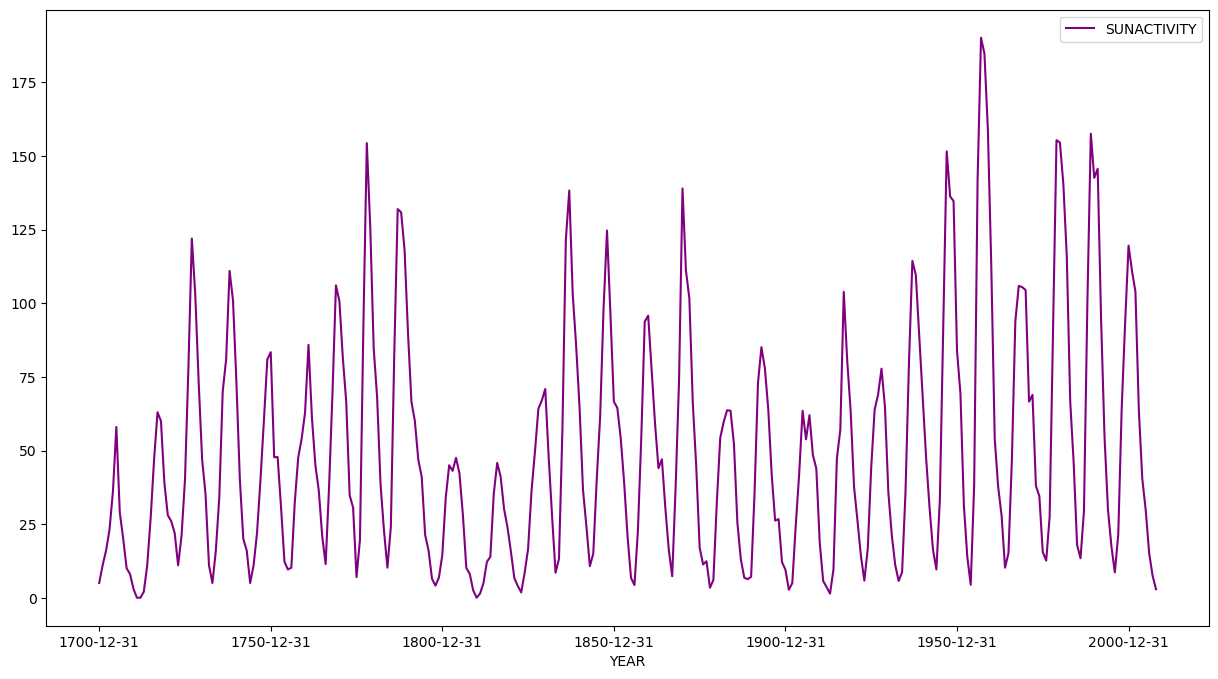

In [4]:
df.plot(figsize=(15,8), color = 'purple')

In [5]:
result = adfuller(df['SUNACTIVITY'])
display(result)

(-2.8377807249381966,
 0.05307642172812041,
 8,
 300,
 {'1%': -3.4523371197407404,
  '5%': -2.871222860740741,
  '10%': -2.571929211111111},
 2430.50034229055)

In [6]:
pvalue =  result[1]
if pvalue < 0.05:
    print("Stationary")
else:
    print("Non Stationary")

Non Stationary


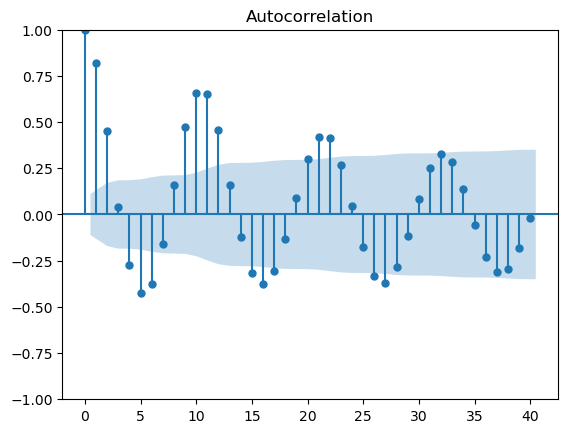

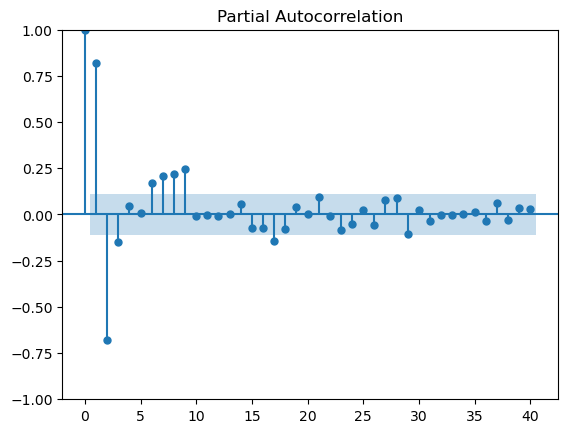

In [7]:
plot_acf(df['SUNACTIVITY'], lags = 40)
plot_pacf(df['SUNACTIVITY'], lags = 40)
plt.show()

In [8]:
model = ARIMA(list(df['SUNACTIVITY']), order = (1,0,1))
result = model.fit()
pred = result.predict()
print(r2_score(df, pred))

0.7707182068955327


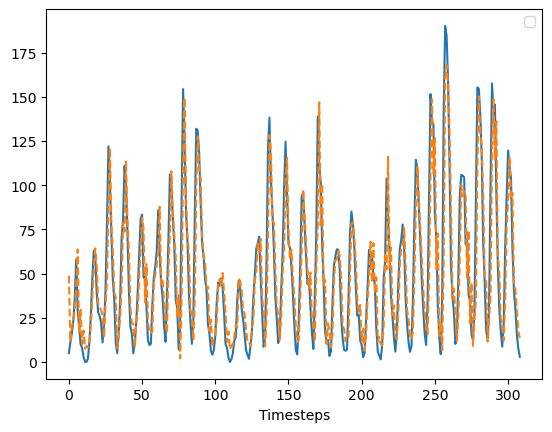

In [9]:
plt.plot(list(df['SUNACTIVITY']))
plt.plot(pred, linestyle = '--')
plt.legend(['Actual Sunspots'], ['Predicted SUnspots'])
plt.xlabel('Timesteps')
plt.show()

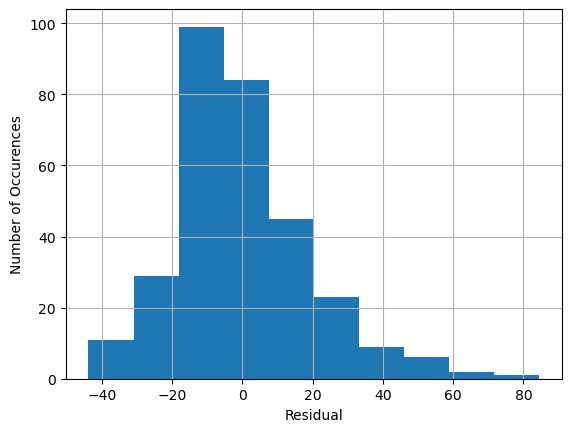

In [10]:
ax = pd.Series(result.resid).hist()
ax.set_xlabel('Residual')
ax.set_ylabel('Number of Occurences')
plt.show()

In [11]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  309
Model:                 ARIMA(1, 0, 1)   Log Likelihood               -1352.613
Date:                Mon, 05 May 2025   AIC                           2713.226
Time:                        20:45:26   BIC                           2728.160
Sample:                             0   HQIC                          2719.197
                                - 309                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.7921      8.077      6.041      0.000      32.962      64.623
ar.L1          0.7355      0.046     15.921      0.000       0.645       0.826
ma.L1          0.5194      0.048     10.798      0.000       0.425       0.614
sigma2       369.1788     25.783     14.319      0.000     318.646     419.712
===================================================================================
Ljung-Box (L1) (Q):                   9.89   Jarque-Bera (JB):                73.24
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                             0.89
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
data_array = df.values
avg_errors = []
for p in range(1):
    for q in range(13):
        errors = []
        tscv = TimeSeriesSplit(test_size = 10)
        for train_index, test_index in tscv.split(data_array):
            x_train, x_test = data_array[train_index], data_array[test_index]
            x_test_orig = x_test

            fcst = []
            for stop in range(10):
                try:
                    mod = ARIMA(x_train, order = (p,0,q))
                    res = mod.fit()
                    fcst.append(res.forecast(steps = 1))
                except:
                    print("Error")
                    fcst.append(-9999999.)
                x_train = np.concatenate((x_train, x_test[0:1,]))
                x_test = x_test[1:]
            errors.append(r2_score(x_test_orig, fcst))
        pq_result = [p, q, np.mean(errors)]
        print(pq_result)
        avg_errors.append(pq_result)
avg_errors = pd.DataFrame(avg_errors)
avg_errors.columns = ['p', 'q', 'error']
result = avg_errors.pivot(index = 'p', columns = 'q')

[0, 0, -0.19537571656493516]
[0, 1, 0.5148074132241574]
[0, 2, 0.6923588109475336]
[0, 3, 0.7314810252053182]
[0, 4, 0.770925030949245]
[0, 5, 0.7808142448369274]
[0, 6, 0.7786783211511368]
[0, 7, 0.7785132494888846]
[0, 8, 0.7616798204291861]
[0, 9, 0.7442644511200823]
[0, 10, 0.700296484012466]
[0, 11, 0.7834745232604089]
[0, 12, 0.669483089135482]


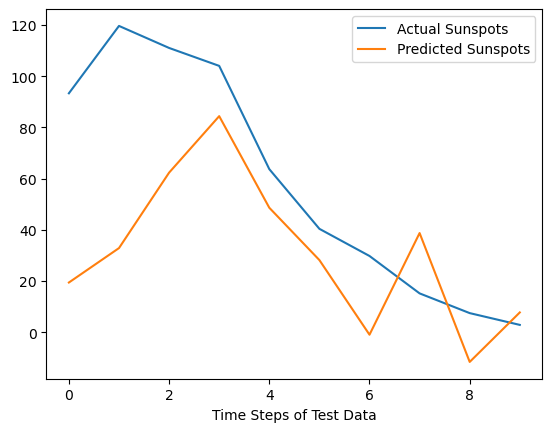

In [13]:
dta_array = df.values
X_train, X_test = dta_array[:10], dta_array[-10:]
X_test_orig = X_test

fcst = []
for step in range(10):
    mod = ARIMA(X_train, order = (10,0,9))
    res = mod.fit()
    fcst.append(res.forecast(steps = 1))
    X_train = np.concatenate((X_train, X_test[0:1,:]))
    X_test = X_test[1:]

plt.plot(X_test_orig)
plt.plot(fcst)
plt.legend(['Actual Sunspots', 'Predicted Sunspots'])
plt.xlabel('Time Steps of Test Data')
plt.show()